In [3]:
import umap

import numpy as np

VIT_PATH = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH = '/home/maria/ProjectionSort/data/brain_area.npy'  


# Load data
vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R = np.load(NEURAL_PATH).T            # shape: (images, neurons)
areas = np.load(AREAS_PATH, allow_pickle=True)         # shape: (neurons,)

top1 = np.argmax(vit, axis=1)

# Step 2 — ImageNet ordering: 0–397 are animals
image_is_animal = (top1 <= 397).astype(bool)

R_animals = R[image_is_animal==True]
R_inanimate = R[image_is_animal==False]

/home/maria/global_venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/maria/global_venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


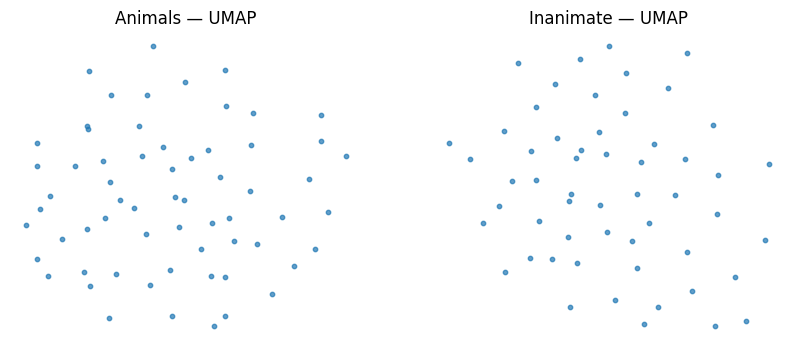

In [4]:
from sklearn.decomposition import PCA
import numpy as np

def run_pca(X, n_components=50):
    """
    Center X, run PCA, return (X_pca, pca).
    X shape: (samples, features)
    """
    # Center
    Xc = X - X.mean(axis=0, keepdims=True)
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(Xc)
    return X_pca, pca

import umap

def run_umap(X_pca, n_neighbors=15, min_dist=0.1):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric='euclidean',
        random_state=42
    )
    X_umap = reducer.fit_transform(X_pca)
    return X_umap, reducer

# animals
X_pca_animals, pca_anim = run_pca(R_animals, n_components=50)
X_umap_animals, umap_anim = run_umap(X_pca_animals)

# inanimate
X_pca_inanim, pca_inanim = run_pca(R_inanimate, n_components=50)
X_umap_inanim, umap_inanim = run_umap(X_pca_inanim)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Animals — UMAP")
plt.scatter(X_umap_animals[:,0], X_umap_animals[:,1], s=10, alpha=0.7)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Inanimate — UMAP")
plt.scatter(X_umap_inanim[:,0], X_umap_inanim[:,1], s=10, alpha=0.7)
plt.axis('off')

plt.show()


/home/maria/global_venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


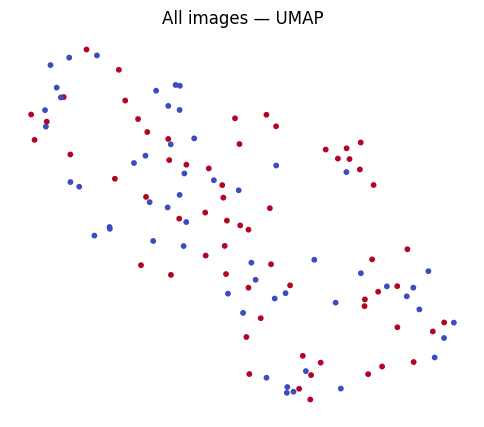

In [11]:
# PCA on full dataset
X_pca_all, pca_all = run_pca(R, n_components=100)
X_umap_all, umap_all = run_umap(X_pca_all, n_neighbors=3)

plt.figure(figsize=(6,5))
plt.title("All images — UMAP")

plt.scatter(
    X_umap_all[:,0],
    X_umap_all[:,1],
    c=image_is_animal,
    cmap='coolwarm',
    s=10
)
plt.axis('off')
plt.show()


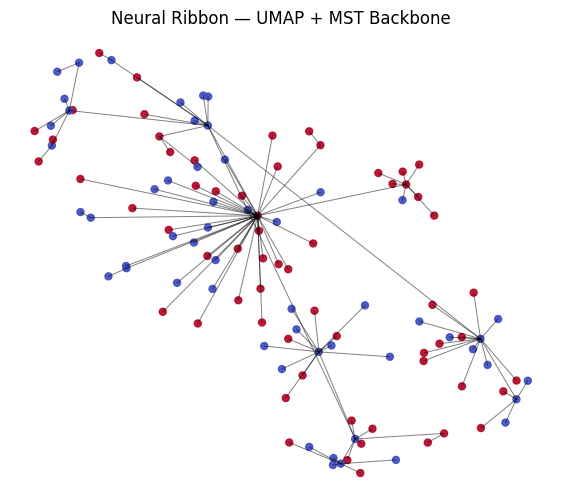

In [12]:
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import pairwise_distances
from scipy.sparse.csgraph import minimum_spanning_tree
import numpy as np

# compute pairwise distances in PCA space
D = pairwise_distances(X_pca_all)

# compute MST
mst = minimum_spanning_tree(D)  # sparse matrix
mst = mst.toarray()

import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.title("Neural Ribbon — UMAP + MST Backbone")

# scatter
plt.scatter(
    X_umap_all[:,0],
    X_umap_all[:,1],
    c=image_is_animal,
    cmap='coolwarm',
    s=25,
    alpha=0.9
)

# draw MST edges
for i in range(len(mst)):
    for j in range(len(mst)):
        if mst[i, j] > 0:
            x1, y1 = X_umap_all[i]
            x2, y2 = X_umap_all[j]
            plt.plot([x1, x2], [y1, y2], color='black', linewidth=0.7, alpha=0.5)

plt.axis('off')
plt.show()


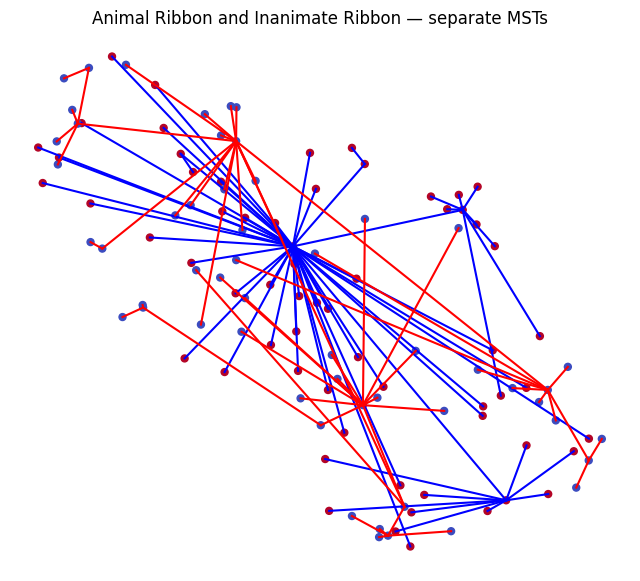

In [13]:
X_pca_anim = X_pca_all[image_is_animal]
X_pca_inanim = X_pca_all[~image_is_animal]

X_umap_anim = X_umap_all[image_is_animal]
X_umap_inanim = X_umap_all[~image_is_animal]

from sklearn.metrics import pairwise_distances
from scipy.sparse.csgraph import minimum_spanning_tree

# animals
D_anim = pairwise_distances(X_pca_anim)
mst_anim = minimum_spanning_tree(D_anim).toarray()

# inanimate
D_inanim = pairwise_distances(X_pca_inanim)
mst_inanim = minimum_spanning_tree(D_inanim).toarray()

plt.figure(figsize=(8,7))
plt.title("Animal Ribbon and Inanimate Ribbon — separate MSTs")

# plot points
plt.scatter(
    X_umap_all[:,0], X_umap_all[:,1],
    c=image_is_animal, cmap='coolwarm', s=25
)

# draw animal MST edges
for i in range(len(mst_anim)):
    for j in range(len(mst_anim)):
        if mst_anim[i, j] > 0:
            x1, y1 = X_umap_anim[i]
            x2, y2 = X_umap_anim[j]
            plt.plot([x1, x2], [y1, y2], color='blue', linewidth=1.5)

# draw inanimate MST edges
for i in range(len(mst_inanim)):
    for j in range(len(mst_inanim)):
        if mst_inanim[i, j] > 0:
            x1, y1 = X_umap_inanim[i]
            x2, y2 = X_umap_inanim[j]
            plt.plot([x1, x2], [y1, y2], color='red', linewidth=1.5)

plt.axis('off')
plt.show()
